# IBM - DATA SCIENCE Courese 9 - CAPSTONE Project

## "FIND SIMILAR NEIGHBORHOODS AMONG DIFFERENT CITIES" ©2020 Claudio Nanni

### This notebook uses k-means clustering to find similar neighborhoods in a city.

Combining the k-means clustering among different cities using the same criteria is possible to not only find similar neighborhoods in the same city but also among different cities.
The main criteria used is the 'category' of the venues that are common in each neighborhood.
Nothing stops from adding other characteristics to add to the 'venues categories' to cluster according to more criteria.

*Datasets used:*
----------------
- datos.gob.es      : Barcelona Neighborhoods

- datos.gob.es      : Madrid Neighborhoods

- geocoder library  : Coordinates of neighborhoods

- FourSquare API    : Venues (around each neighborhood)


*Cities studied:*
-----------------
- BARCELONA
- MADRID

## PART 1 - Clustering Neighboroods from City #1 - Barcelona

In [1]:
####################################
#          IMPORTS SECTOR          #
####################################
print('---------------Importing libraries----------------')
!conda install -c conda-forge bs4 --yes
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge geocoder --yes
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge lxml --yes
!conda install -c conda-forge idealista-api-python --yes
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from io import StringIO
from pandas.io.json import json_normalize
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
from urllib.request import urlopen
import folium # map rendering library
import geocoder # import geocoder
import json
import json # library to handle JSON files
#import k-means from clustering stage
import lxml
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests
import requests # library to handle requests
#IMPORTS SECTOR
import ssl
import urllib.request
# Matplotlib and associated plotting modules
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('---------------Libraries imported----------------')

---------------Importing libraries----------------
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - bs4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.0       |   py36h9f0ad1d_0         160 KB  conda-forge
    bs4-4.9.0                  |                0           4 KB  conda-forge
    soupsieve-1.9.4            |   py36h9f0ad1d_1          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         222 KB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-forge/linux-64::beautifulsoup4-4.9.0-py36h9f0ad1d_0
  bs4                conda-forge/noarch::bs4-4.9.0-0
  soupsieve          conda-forge/linux-64::soupsieve-1.9.4-py36h9f0ad1d_1



soupsieve-1.9.4      | 58 KB     | #####

In [2]:
############################################################################################################
#             IMPORT BARCELONA DISTRICTS directly from Spain Government Open Data portal                   #
############################################################################################################
url="https://datos.gob.es/apidata/catalog/dataset/l01080193-superficie-por-barrios-de-la-ciudad-de-barcelona1"
response = urlopen(url,context=ssl._create_unverified_context())
json_data = response.read().decode('utf-8', 'replace')
data=pd.read_json(json_data)
b=pd.DataFrame(data['result']['items'][0]['keyword'])
b.rename(columns={0:'Neighborhood'},inplace=True)
patt='^Año|^Barrio'
filt=b['Neighborhood'].str.contains(patt)
barrios=b[~filt]
barrios
cdf=barrios
cdf.head()

,Neighborhood
13,Baró de Viver
14,Bon Pastor
15,Can Baró
16,Can Peguera
17,Canyelles


In [3]:
print(cdf.shape)

(76, 1)


## Clustering Barcelona Neighborhoods ##

In [4]:
#################################################################
#             SOME DATA NEEDS MANUAL CLEANING                   #
#################################################################

### MANUAL CLEANING OF DATA
prob1='el Camp d en Grassot i Gràcia Nova'
prob2='el Camp de l Arpa del Clot'
prob3='l Antiga Esquerra de l Eixample'
prob4='la Vall d Hebron'

sol1='Camp d\'en Grassot'
sol2='Camp de l\'Arpa'
sol3='Antiga Esquerra de l\'Eixample'
sol4='Vall d\'Hebron'

#cdf[cdf['Neighborhood']==prob1].Neighborhood=sol1
#cdf[cdf['Neighborhood']==prob2].Neighborhood=sol2
#cdf[neighborhoods['Neighborhood']==prob3].Neighborhood=sol3
#cdf[neighborhoods['Neighborhood']==prob4].Neighborhood=sol4
    
cdf['Neighborhood'][51]=sol1
cdf['Neighborhood'][52]=sol2
cdf['Neighborhood'][64]=sol3
cdf['Neighborhood'][83]=sol4

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
### BETA
###############################################################
#             Download Avg Price per Barrio                   #
###############################################################
avg_price_bcn=pd.DataFrame()
avg_price_bcn.drop
headers = {'User-Agent': 'IBM Capstone'}
url="https://opendata-ajuntament.barcelona.cat/data/dataset/d9f7d804-bcc6-4a3f-9c26-44cd84c4402e/resource/c9defbfa-0b58-49db-85ed-cf13f165a5d5/download"
avg_price_bcn=pd.read_csv(url)
avg_price_bcn.rename(columns={'Nom_Barri':'Neighborhood'},inplace=True)
idx=avg_price_bcn['Preu_mitja_habitatge'].str.contains('Total. Milers d\'euros')
avg_totprice_bcn=avg_price_bcn.loc[idx,['Neighborhood','Valor','Trimestre']]
idx=avg_totprice_bcn['Trimestre']==1
avg_price_bcn=avg_totprice_bcn.loc[idx,['Neighborhood','Valor']]


cdf2 = pd.DataFrame()
cdf2 = cdf.join(avg_price_bcn.set_index('Neighborhood'), on='Neighborhood')
cdf2.head(80)



,Neighborhood,Valor
13,Baró de Viver,NaN
14,Bon Pastor,NaN
15,Can Baró,252.2
16,Can Peguera,NaN
17,Canyelles,150.0
18,Ciutat Meridiana,95.2
19,Diagonal Mar i el Front Marítim del Poblenou,486.2
20,Fort Pienc,NaN
21,Horta,266.9
22,Hostafrancs,210.6


In [6]:
#####################################################################################################
#             Using the geolocator library we get the coordinates of each neighborhood              #
#####################################################################################################

neighborhoods=''
neighborhoods=pd.DataFrame(columns=['Neighborhood','Latitude','Longitude'])

for index,row in cdf2.iterrows():
    address = row['Neighborhood'] + ", Barcelona"
    geolocator = Nominatim(user_agent="barcelona explorer")
    location = geolocator.geocode(address)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
        onerow={'Neighborhood': row['Neighborhood'], 'Latitude':latitude, 'Longitude':longitude}
        #print(onerow)
        neighborhoods=neighborhoods.append(onerow,ignore_index=True)
        # print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))
    if location is None:
        print('{} does not have geocoding info, excluding.'.format(address))

In [7]:
neighborhoods.shape

(76, 3)

In [8]:
#####################################################################################################
#             Using Folium we plot the map and visualize the neighborhoods on the map               #
#####################################################################################################

map_barcelona = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng,  neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_barcelona)  
map_barcelona

In [9]:
#####################################################################################################
#             Analysing a subset of neighborhoods. test_borough contains the string to search       #
#####################################################################################################

test_borough=''
test_borough_regex= '.*' + test_borough + '.*'
barrios_of_interest = neighborhoods[neighborhoods.Neighborhood.str.match(test_borough_regex)].reset_index(drop=True)
barrios_of_interest.head()
print('{} has {} neighborhoods'.format(test_borough,barrios_of_interest.shape[0]))
barrios_of_interest.head()

 has 76 neighborhoods


,Neighborhood,Latitude,Longitude
0,Baró de Viver,41.445934,2.198788
1,Bon Pastor,41.436110,2.204807
2,Can Baró,41.416966,2.162693
3,Can Peguera,41.434928,2.166548
4,Canyelles,41.285827,1.722274


In [10]:
# We get the coordinates the test neighborhoods - In this case we get all of them
address = test_borough +', Barcelona'
address
geolocator = Nominatim(user_agent="barcelona_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of , Barcelona are 41.3828939, 2.1774322.


In [11]:
# This map is different from the previous only if we looked at a subset of neighborhoods 

# NOTE: We don't filter out neighborhoods in this excercise

map_of_interest = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(barrios_of_interest['Latitude'], barrios_of_interest['Longitude'], barrios_of_interest['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_of_interest)  
    
map_of_interest

In [12]:
#######################################################
#              FourSquare API credentials             #
#######################################################

#CLIENT_ID = 'BQM5DYRRYYJOB1MAXJMU53OCFPKFPK51BSAKMRYXLDNYV11R' # your Foursquare ID
#CLIENT_SECRET = 'GWBDAL0H5R03OS2HI1TD0SOZIY3VBHGV0Z5Y1NBOJCWATPRS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#Second account, hit quota
CLIENT_ID = 'TSH4O4RSHMKBUCY0U02NKHMUBKPCQ0EJEQCZMLMDZ1G0O35I' # your Foursquare ID
CLIENT_SECRET = 'TDTO32RERLNFJZFA1Z5NZJWNCTY230I4NE1PH3OBF5NSA5ZC' # your Foursquare Secret

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TSH4O4RSHMKBUCY0U02NKHMUBKPCQ0EJEQCZMLMDZ1G0O35I
CLIENT_SECRET:TDTO32RERLNFJZFA1Z5NZJWNCTY230I4NE1PH3OBF5NSA5ZC


In [13]:
# Let's have a look at the first neighborhood in the dataframe
test_neighborhood=barrios_of_interest.loc[0, 'Neighborhood']
test_neighborhood

'Baró de Viver'

In [14]:
# We get the coordinates of the first neighborhood in the test subset
neighborhood_latitude = barrios_of_interest.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = barrios_of_interest.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = barrios_of_interest.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Baró de Viver are 41.44593355, 2.19878770617065.


In [15]:
# We prepare the API call to find venues in FourSquare
LIMIT = 300
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=TSH4O4RSHMKBUCY0U02NKHMUBKPCQ0EJEQCZMLMDZ1G0O35I&client_secret=TDTO32RERLNFJZFA1Z5NZJWNCTY230I4NE1PH3OBF5NSA5ZC&v=20180605&ll=41.44593355,2.19878770617065&radius=500&limit=300'

In [16]:
# Actual call to FourSquare here
results = requests.get(url).json()
#print(results)


In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
###################################################################
#             Extract the venues from the json result file        #
###################################################################


# Venues in the Neighborhood
venues = results['response']['groups'][0]['items']

# flatten JSON
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row - using the function get_category_type() defined above
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,name,categories,lat,lng
0,Ibericus,Food,41.441505,2.197812
1,Pasteleria Buenavista,Dessert Shop,41.442172,2.199977
2,A Loja do Gato Preto,Furniture / Home Store,41.441689,2.197742
3,Restaurante Avenida II,Restaurant,41.443000,2.202642
4,Parc del Nus de la Trinitat,Park,41.449112,2.195828
5,Enrique Tomás - C.C. La Maquinista Local 004,Deli / Bodega,41.442171,2.197763
6,Wok You,Asian Restaurant,41.442989,2.200887
7,Drim,Toy / Game Store,41.441612,2.197790
8,Mister Guau,Pet Store,41.441843,2.197756
9,Wook Restaurante,Diner,41.443027,2.200704


In [19]:
print('{} venues were returned by Foursquare for the first neighborhood {} in borough {}.'.format(nearby_venues.shape[0], test_neighborhood, test_borough))

11 venues were returned by Foursquare for the first neighborhood Baró de Viver in borough .


## Explore Neighborhoods in Barcelona


In [20]:
#####################################################################
#             Function to get Venues near a Neighborhood            #
#####################################################################

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
# Get all venues for all barrios
barrios_venues = getNearbyVenues(names=barrios_of_interest['Neighborhood'],
                                   latitudes=barrios_of_interest['Latitude'],
                                   longitudes=barrios_of_interest['Longitude']
                                  )

Baró de Viver
Bon Pastor
Can Baró
Can Peguera
Canyelles
Ciutat Meridiana
Diagonal Mar i el Front Marítim del Poblenou
Fort Pienc
Horta
Hostafrancs
Les Roquetes
Montbau
Navas
Pedralbes
Poble-sec
Poblenou
Porta
Provençals del Poblenou
Sant Andreu
Sant Antoni
Sant Genís dels Agudells
Sant Gervasi-Galvany
Sant Gervasi-la Bonanova
Sant Martí de Provençals
Sant Pere
Santa Caterina i la Ribera
Sants
Sants - Badal
Sarrià
Superficie
Torre Baró
Vallbona
Vallcarca i els Penitents
Vallvidrera
Verdun
Vilapicina i la Torre Llobeta
el Baix Guinardó
el Besòs i el Maresme
Camp d'en Grassot
Camp de l'Arpa
el Carmel
el Clot
el Coll
el Congrés i els Indians
el Guinardó
el Gòtic
el Parc i la Llacuna del Poblenou
el Putxet i el Farró
el Raval
el Tibidabo i les Planes
el Turó de la Peira
Antiga Esquerra de l'Eixample
la Barceloneta
la Bordeta
la Clota
la Dreta de l Eixample
la Font d en Fargues
la Font de la Guatlla
la Guineueta
la Marina de Port
la Marina del Prat Vermell
la Maternitat i Sant Ramon
la Nova 

In [22]:
print(barrios_venues.shape)
barrios_venues.head(10)

(2930, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Baró de Viver,41.445934,2.198788,Ibericus,41.441505,2.197812,Food
1,Baró de Viver,41.445934,2.198788,Pasteleria Buenavista,41.442172,2.199977,Dessert Shop
2,Baró de Viver,41.445934,2.198788,A Loja do Gato Preto,41.441689,2.197742,Furniture / Home Store
3,Baró de Viver,41.445934,2.198788,Restaurante Avenida II,41.443000,2.202642,Restaurant
4,Baró de Viver,41.445934,2.198788,Parc del Nus de la Trinitat,41.449112,2.195828,Park
5,Baró de Viver,41.445934,2.198788,Enrique Tomás - C.C. La Maquinista Local 004,41.442171,2.197763,Deli / Bodega
6,Baró de Viver,41.445934,2.198788,Wok You,41.442989,2.200887,Asian Restaurant
7,Baró de Viver,41.445934,2.198788,Drim,41.441612,2.197790,Toy / Game Store
8,Baró de Viver,41.445934,2.198788,Mister Guau,41.441843,2.197756,Pet Store
9,Baró de Viver,41.445934,2.198788,Wook Restaurante,41.443027,2.200704,Diner


In [23]:
barrios_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Antiga Esquerra de l'Eixample,100,100,100,100,100,100
Baró de Viver,11,11,11,11,11,11
Bon Pastor,4,4,4,4,4,4
Camp d'en Grassot,62,62,62,62,62,62
Camp de l'Arpa,36,36,36,36,36,36
Can Baró,21,21,21,21,21,21
Can Peguera,10,10,10,10,10,10
Canyelles,4,4,4,4,4,4
Ciutat Meridiana,7,7,7,7,7,7


In [24]:
barrios_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,2,2,2,2,2,2
African Restaurant,2,2,2,2,2,2
American Restaurant,5,5,5,5,5,5
Amphitheater,1,1,1,1,1,1
Antique Shop,2,2,2,2,2,2
Aquarium,1,1,1,1,1,1
Arcade,2,2,2,2,2,2
Arepa Restaurant,1,1,1,1,1,1
Argentinian Restaurant,14,14,14,14,14,14


In [25]:
print('There are {} uniques categories.'.format(len(barrios_venues['Venue Category'].unique())))

There are 274 uniques categories.


### HERE WE GROUP VENUES TYPES THAT ARE REALLY SIMILAR, CLUSTERING SUFFERS FROM NON-SIGNIFICANT DIFFERENCE IN CATEGORIES


In [26]:
idx=barrios_venues['Venue Category'].str.contains('Restaurant|Gastro|Bistro|BBQ|Steak|Taverna')
barrios_venues.loc[idx,'Venue Category']='Restaurant'

idx=barrios_venues['Venue Category'].str.contains('Bar|Coffee|Cafe|Café|Breakfast|Wine')
barrios_venues.loc[idx,'Venue Category']='Bar'

idx=barrios_venues['Venue Category'].str.contains('Theater')
barrios_venues.loc[idx,'Venue Category']='Theater'

idx=barrios_venues['Venue Category'].str.contains('Grocery|Food|Fish Market|Farmers Market|Deli')
barrios_venues.loc[idx,'Venue Category']='Supermarket'

idx=barrios_venues['Venue Category'].str.contains('Ice|Pizza|Burger|Salad|Snack|Sandwich|Chicken|Taco|Noodle|Pastry|Pie|Yogurt|Chips|Creperie|Cupcake|Burrito|Dessert')
barrios_venues.loc[idx,'Venue Category']='Fast Food'

idx=barrios_venues['Venue Category'].str.contains('Beer|Brewery')
barrios_venues.loc[idx,'Venue Category']='Beer'

idx=barrios_venues['Venue Category'].str.contains('Art|Exhibit|Museum')
barrios_venues.loc[idx,'Venue Category']='Art'

idx=barrios_venues['Venue Category'].str.contains('Park')
barrios_venues.loc[idx,'Venue Category']='Park'

idx=barrios_venues['Venue Category'].str.contains('Bus|Train|Station|Transport')
barrios_venues.loc[idx,'Venue Category']='Transport'

idx=barrios_venues['Venue Category'].str.contains('Nail|Beauty|Massage|Spa')
barrios_venues.loc[idx,'Venue Category']='Beauty Salon'

idx=barrios_venues['Venue Category'].str.contains('Chocolate|Cheese|Donut|Fruit')
barrios_venues.loc[idx,'Venue Category']='Supermarket'

idx=barrios_venues['Venue Category'].str.contains('Garden')
barrios_venues.loc[idx,'Venue Category']='Garden'

idx=barrios_venues['Venue Category'].str.contains('Gym|Fitness|Yoga')
barrios_venues.loc[idx,'Venue Category']='Gym'

idx=barrios_venues['Venue Category'].str.contains('Hostel')
barrios_venues.loc[idx,'Venue Category']='Hotel'

idx=barrios_venues['Venue Category'].str.contains('Outdoor')
barrios_venues.loc[idx,'Venue Category']='Park'

idx=barrios_venues['Venue Category'].str.contains('Travel')
barrios_venues.loc[idx,'Venue Category']='Travel'

idx=barrios_venues['Venue Category'].str.contains('Football|Bowling|Hockey|Gym|Tennis|Sport|Basketball')
barrios_venues.loc[idx,'Venue Category']='Sport'

idx=barrios_venues['Venue Category'].str.contains('Tree')
barrios_venues.loc[idx,'Venue Category']='Park'

#barrios_venues.head()

print('There are {} uniques categories.'.format(len(barrios_venues['Venue Category'].unique())))

There are 125 uniques categories.


In [27]:
# This is a sort of bitmap encoding, a grid of venues and neighborhoods

# one hot encoding
barrios_onehot = pd.get_dummies(barrios_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
barrios_onehot['Neighborhood'] = barrios_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [barrios_onehot.columns[-1]] + list(barrios_onehot.columns[:-1])
barrios_onehot = barrios_onehot[fixed_columns]

barrios_onehot.head()

,Zoo,Accessories Store,Amphitheater,Antique Shop,Aquarium,Arcade,Art,Auto Garage,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bar,Beach,Beauty Salon,Beer,Big Box Store,Bike Rental / Bike Share,Board Shop,Boarding House,Bookstore,Boutique,Bridge,Buffet,Building,Camera Store,Candy Store,Casino,Castle,Circus,Clothing Store,College Residence Hall,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cultural Center,Dance Studio,Department Store,Diner,Doctor's Office,Dog Run,Electronics Store,Fabric Shop,Fast Food,Flea Market,Flower Shop,Fountain,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Gourmet Shop,Hardware Store,Historic Site,Hobby Shop,Hot Dog Joint,Hot Spring,Hotel,Hotel Pool,Irish Pub,Jazz Club,Kids Store,Liquor Store,Lounge,Market,Medical Center,Memorial Site,Men's Store,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Multiplex,Music Store,Music Venue,Neighborhood,Nightclub,Opera House,Optical Shop,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Planetarium,Playground,Plaza,Pool,Post Office,Print Shop,Pub,Record Shop,Restaurant,Road,Rock Club,Roof Deck,Sauna / Steam Room,Scenic Lookout,Shoe Store,Shopping Mall,Smoke Shop,Soccer Field,Soccer Stadium,Speakeasy,Sport,Stables,Stadium,Supermarket,Surf Spot,Tea Room,Tech Startup,Theater,Tourist Information Center,Toy / Game Store,Track,Transport,Travel,Tunnel,University,Video Game Store,Video Store,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Baró de Viver,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
barrios_onehot.shape

(2930, 125)

In [29]:
barrios_grouped = barrios_onehot.groupby('Neighborhood').mean().reset_index()
#barrios_grouped

In [30]:
barrios_grouped.shape

(74, 125)

In [31]:
# Let's explore the top venues for each neighborhood, it can help with the decision for kmeans clustering
num_top_venues = 5

for hood in barrios_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = barrios_grouped[barrios_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Antiga Esquerra de l'Eixample----
         venue  freq
0   Restaurant  0.36
1          Bar  0.19
2  Supermarket  0.14
3        Hotel  0.08
4    Fast Food  0.06


----Baró de Viver----
                    venue  freq
0             Supermarket  0.27
1              Restaurant  0.18
2  Furniture / Home Store  0.09
3        Toy / Game Store  0.09
4               Fast Food  0.09


----Bon Pastor----
       venue  freq
0        Bar  0.50
1      Sport  0.25
2     Bakery  0.25
3        Zoo  0.00
4  Pet Store  0.00


----Camp d'en Grassot----
         venue  freq
0   Restaurant  0.47
1          Bar  0.11
2  Supermarket  0.10
3       Bakery  0.06
4        Hotel  0.05


----Camp de l'Arpa----
         venue  freq
0   Restaurant  0.53
1    Fast Food  0.11
2  Supermarket  0.08
3       Bakery  0.08
4        Hotel  0.06


----Can Baró----
            venue  freq
0      Restaurant  0.33
1             Bar  0.10
2  Scenic Lookout  0.10
3     Supermarket  0.10
4           Sport  0.05


----Can Peguera

In [32]:
# Return 'num_top_venues' venues from each Neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
######################################################################################################
# This block creates a table with 'num_top_venues' venues for each neighborhood orderd by popularity #
######################################################################################################


num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = barrios_grouped['Neighborhood']

for ind in np.arange(barrios_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barrios_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Antiga Esquerra de l'Eixample,Restaurant,Bar,Supermarket,Hotel,Fast Food
1,Baró de Viver,Supermarket,Restaurant,Park,Toy / Game Store,Fast Food
2,Bon Pastor,Bar,Bakery,Sport,Women's Store,Diner
3,Camp d'en Grassot,Restaurant,Bar,Supermarket,Bakery,Hotel
4,Camp de l'Arpa,Restaurant,Fast Food,Bakery,Supermarket,Hotel


In [34]:
#######################################################
#              K-Means Clustering RUNS HERE           #
#######################################################
# set number of clusters
kclusters = 7
barrios_grouped_clustering = barrios_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barrios_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 2, 3, 3, 3, 1, 3, 4, 3], dtype=int32)

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
barrios_merged = barrios_of_interest
# merge dataframes to add latitude/longitude for each neighborhood
barrios_merged = barrios_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
barrios_merged.head() # check the last columns!

#Some neighborhood fall into NaN category, we eliminate them.
barrios_merged.dropna(inplace=True)
barrios_merged['Cluster Labels']

0     1.0
1     2.0
2     3.0
3     1.0
4     3.0
5     4.0
6     3.0
7     1.0
8     3.0
9     3.0
10    0.0
11    0.0
12    3.0
13    0.0
14    3.0
15    3.0
16    1.0
17    3.0
18    3.0
19    3.0
20    1.0
21    3.0
22    0.0
23    1.0
25    0.0
26    3.0
27    1.0
28    3.0
29    3.0
30    6.0
31    4.0
32    5.0
33    5.0
34    3.0
35    1.0
36    3.0
37    0.0
38    3.0
39    3.0
40    5.0
41    3.0
43    3.0
44    0.0
45    3.0
46    3.0
47    3.0
48    3.0
49    3.0
50    1.0
51    3.0
52    3.0
53    1.0
54    5.0
55    0.0
56    1.0
57    0.0
58    1.0
59    1.0
60    1.0
61    0.0
62    3.0
63    1.0
64    3.0
65    1.0
66    0.0
67    1.0
68    5.0
69    3.0
70    1.0
71    1.0
72    3.0
73    3.0
74    3.0
75    3.0
Name: Cluster Labels, dtype: float64

In [36]:
#########################################################################################
#              Map neighborhoods with color coding based on the cluster label           #
#########################################################################################

# Not sure why it complains of floats depending on the Borough!
barrios_merged['Cluster Labels']=barrios_merged['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gnuplot(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barrios_merged['Latitude'], barrios_merged['Longitude'], barrios_merged['Neighborhood'], barrios_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Above the clustering result for the city of Barcelona

In [37]:
# Below the cluster labels and neighborhoods belonging to them
from IPython.display import display, HTML

for i in range(kclusters):
    print("CLUSTER LABEL: {}".format(i))
    tx=barrios_merged.loc[barrios_merged['Cluster Labels'] == i, barrios_merged.columns[[0] + list(range(4, barrios_merged.shape[1]))]]
    display(tx)

CLUSTER LABEL: 0


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Les Roquetes,Sport,Baby Store,Restaurant,Diner,Music Venue
11,Montbau,Restaurant,Sport,Plaza,Park,Soccer Stadium
13,Pedralbes,Bar,Restaurant,Garden,Park,Hot Dog Joint
22,Sant Gervasi-la Bonanova,Restaurant,Sport,Planetarium,Plaza,Bar
25,Santa Caterina i la Ribera,Bar,Restaurant,Fast Food,Park,Supermarket
37,el Besòs i el Maresme,Sport,Diner,Hotel,Restaurant,Supermarket
44,el Guinardó,Bar,Restaurant,Sport,Supermarket,Plaza
55,la Dreta de l Eixample,Hotel,Restaurant,Fast Food,Bar,Supermarket
57,la Font de la Guatlla,Restaurant,Bar,Fast Food,Sport,Supermarket
61,la Maternitat i Sant Ramon,Sport,Soccer Field,Transport,Bar,Nightclub


CLUSTER LABEL: 1


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Baró de Viver,Supermarket,Restaurant,Park,Toy / Game Store,Fast Food
3,Can Peguera,Restaurant,Supermarket,Park,Hotel,Plaza
7,Fort Pienc,Restaurant,Supermarket,Bar,Sport,Soccer Stadium
16,Porta,Restaurant,Supermarket,Fast Food,Plaza,Clothing Store
20,Sant Genís dels Agudells,Supermarket,Sport,Restaurant,Bar,Department Store
23,Sant Martí de Provençals,Restaurant,Supermarket,Sport,Bar,Fast Food
27,Sants - Badal,Restaurant,Supermarket,Bar,Fast Food,Bakery
35,Vilapicina i la Torre Llobeta,Restaurant,Supermarket,Bar,Fast Food,Bookstore
50,el Turó de la Peira,Restaurant,Supermarket,Fast Food,Bar,Hot Dog Joint
53,la Bordeta,Restaurant,Fast Food,Supermarket,Bar,Hotel


CLUSTER LABEL: 2


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Bon Pastor,Bar,Bakery,Sport,Women's Store,Diner


CLUSTER LABEL: 3


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Can Baró,Restaurant,Scenic Lookout,Supermarket,Bar,Plaza
4,Canyelles,Restaurant,Soccer Stadium,Fast Food,Women's Store,Electronics Store
6,Diagonal Mar i el Front Marítim del Poblenou,Restaurant,Bar,Sport,Beach,Hotel
8,Horta,Restaurant,Fast Food,Park,Bar,Plaza
9,Hostafrancs,Restaurant,Bar,Fast Food,Hotel,Bakery
12,Navas,Restaurant,Sport,Plaza,Fast Food,Women's Store
14,Poble-sec,Restaurant,Bar,Fast Food,Hotel,Supermarket
15,Poblenou,Restaurant,Fast Food,Bar,Bakery,Supermarket
17,Provençals del Poblenou,Restaurant,Bar,Hotel,Sport,Playground
18,Sant Andreu,Restaurant,Fast Food,Clothing Store,Bar,Supermarket


CLUSTER LABEL: 4


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Ciutat Meridiana,Transport,Supermarket,Plaza,Park,Women's Store
31,Vallbona,Transport,Restaurant,Sport,Women's Store,Cultural Center


CLUSTER LABEL: 5


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
32,Vallcarca i els Penitents,Bar,Supermarket,Fast Food,Restaurant,Hotel
33,Vallvidrera,Park,Plaza,Fast Food,Transport,Restaurant
40,el Carmel,Supermarket,Bar,Plaza,Park,Sport
54,la Clota,Park,Supermarket,Bakery,Restaurant,Bar
68,la Trinitat Nova,Supermarket,Plaza,Pharmacy,Music Venue,Restaurant


CLUSTER LABEL: 6


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
30,Torre Baró,Scenic Lookout,Women's Store,Fabric Shop,Comedy Club,Comic Shop


# SECOND CITY  - STARTS HERE
## MADRID

In [38]:
############################################################################################################
#             IMPORT BARCELONA DISTRICTS directly from Spain Government Open Data portal                   #
############################################################################################################

## Unfortunately the XLS file I've found is badly parsable, so I decided to export the data, clean it manually and upload it to github
data.drop
headers = {'User-Agent': 'IBM Capstone'}
url="https://raw.githubusercontent.com/claudionanni/Coursera_Capstone/master/madrid_barrios.csv"
data=pd.read_csv(url,header=None)

In [39]:
data.rename(columns={0:'Code',1:'Neighborhood'},inplace=True)
cdf=data
cdf.head(10)

,Code,Neighborhood
0,11,Palacio
1,12,Embajadores
2,13,Cortes
3,14,Justicia
4,15,Universidad
5,16,Sol
6,21,Imperial
7,22,Acacias
8,23,Chopera
9,24,Legazpi


In [40]:
print(cdf.shape)
neighborhoods=cdf

(132, 2)


## Clustering Madrid Neighborhoods ##

In [41]:
#####################################################################################################
#             Using the geolocator library we get the coordinates of each neighborhood              #
#####################################################################################################
neighborhoods.drop
neighborhoods=pd.DataFrame(columns=['Neighborhood','Latitude','Longitude'])

for index,row in cdf.iterrows():
    address = row['Neighborhood'] + ", Madrid"
    geolocator = Nominatim(user_agent="madrid explorer")
    location = geolocator.geocode(address)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
        onerow={'Neighborhood': row['Neighborhood'], 'Latitude':latitude, 'Longitude':longitude}
        #print(onerow)
        neighborhoods=neighborhoods.append(onerow,ignore_index=True)
        # print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))
    if location is None:
        print('{} does not have geocoding info, excluding.'.format(address))

Valderrivas, Madrid does not have geocoding info, excluding.
Casco Histórico de Barajas, Madrid does not have geocoding info, excluding.


In [42]:
# Need to clean up text for missing barrios

In [43]:
neighborhoods.shape

(130, 3)

In [44]:
# We get the coordinates the test neighborhoods
address = 'Madrid'
address
geolocator = Nominatim(user_agent="madrid_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of Madrid are 40.4167047, -3.7035825.


In [45]:
# Let's create the map of Madrid with all the Neighborhoods
cityMap = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cityMap)  
cityMap

In [46]:
# Let's focus on all Boroughs from Madrid
test_borough=''
test_borough_regex= '.*' + test_borough + '.*'
barrios_of_interest_2 = neighborhoods[neighborhoods.Neighborhood.str.match(test_borough_regex)].reset_index(drop=True)
#downtown_toronto_data = neighborhoods[neighborhoods['Borough'] == test_borough].reset_index(drop=True)
barrios_of_interest_2.head()
print('{} has {} neighborhoods'.format(test_borough,barrios_of_interest_2.shape[0]))

 has 130 neighborhoods


In [47]:
# We get the coordinates of "Madrid"
address = 'Madrid'
address
geolocator = Nominatim(user_agent="city explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of Madrid are 40.4167047, -3.7035825.


In [48]:
# This map is different from the previous only if we look at a subset of boroughs
map_of_interest = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(barrios_of_interest_2['Latitude'], barrios_of_interest_2['Longitude'], barrios_of_interest_2['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_of_interest)  
    
map_of_interest

In [49]:
#######################################################
#              FourSquare API credentials             #
#######################################################

## SET ABOVE ON THE FIRST CITY STUDY
##CLIENT_ID = 'TSH4O4RSHMKBUCY0U02NKHMUBKPCQ0EJEQCZMLMDZ1G0O35I' # your Foursquare ID
##CLIENT_SECRET = 'TDTO32RERLNFJZFA1Z5NZJWNCTY230I4NE1PH3OBF5NSA5ZC' # your Foursquare Secret
##VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TSH4O4RSHMKBUCY0U02NKHMUBKPCQ0EJEQCZMLMDZ1G0O35I
CLIENT_SECRET:TDTO32RERLNFJZFA1Z5NZJWNCTY230I4NE1PH3OBF5NSA5ZC


In [50]:
# Let's have a look at the first neighborhood in the dataframe
test_neighborhood=barrios_of_interest_2.loc[0, 'Neighborhood']
test_neighborhood

'Palacio'

In [51]:
# We get the coordinates of the first neighborhood in Madrid
neighborhood_latitude = barrios_of_interest_2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = barrios_of_interest_2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = barrios_of_interest_2.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Palacio are 40.41512925, -3.7156179983990922.


In [52]:
# We prepare the API call to find venues in FourSquare
LIMIT = 300
radius = 300
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=TSH4O4RSHMKBUCY0U02NKHMUBKPCQ0EJEQCZMLMDZ1G0O35I&client_secret=TDTO32RERLNFJZFA1Z5NZJWNCTY230I4NE1PH3OBF5NSA5ZC&v=20180605&ll=40.41512925,-3.7156179983990922&radius=300&limit=300'

In [53]:
# Actual call to FourSquare here
results = requests.get(url).json()
#results

In [54]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [55]:
# Venues in the Neighborhood
venues = results['response']['groups'][0]['items']

# flatten JSON
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row - using the function get_category_type() defined above
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng
0,Santa Iglesia Catedral de Santa María la Real ...,Church,40.415767,-3.714516
1,Plaza de La Almudena,Plaza,40.416320,-3.713777
2,Cervecería La Mayor,Beer Bar,40.415218,-3.712194
3,Taberna Rayuela,Tapas Restaurant,40.413179,-3.713496
4,Charlie Champagne,Restaurant,40.413936,-3.712647


In [56]:
print('{} venues were returned by Foursquare for the first neighborhood {} in borough {}.'.format(nearby_venues.shape[0], test_neighborhood, test_borough))

20 venues were returned by Foursquare for the first neighborhood Palacio in borough .


## Explore Neighborhoods in Madrid


In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
barrios_venues_2 = getNearbyVenues(names=barrios_of_interest_2['Neighborhood'],
                                   latitudes=barrios_of_interest_2['Latitude'],
                                   longitudes=barrios_of_interest_2['Longitude']
                                  )

Palacio
Embajadores
Cortes
Justicia
Universidad
Sol
Imperial
Acacias
Chopera
Legazpi
Delicias
Palos de Moguer
Atocha
Pacífico
Adelfas
Estrella
Ibiza
Jerónimos
Niño Jesús
Recoletos
Goya
Fuente del Berro
Guindalera
Lista
Castellana
El Viso
Prosperidad
Ciudad Jardín
Hispanoamérica
Nueva España
Castilla
Bellas Vistas
Cuatro Caminos
Castillejos
Almenara
Valdeacederas
Berruguete
Gaztambide
Arapiles
Trafalgar
Almagro
Ríos Rosas
Vallehermoso
El Pardo
Fuentelarreina
Peñagrande
Pilar
La Paz
Valverde
Mirasierra
El Goloso
Casa de Campo
Argüelles
Ciudad Universitaria
Valdezarza
Valdemarín
El Plantío
Aravaca
Los Cármenes
Puerta del Angel
Lucero
Aluche
Campamento
Cuatro Vientos
Las Águilas
Comillas
Opañel
San Isidro
Vista Alegre
Puerta Bonita
Buenavista
Abrantes
Orcasitas
Orcasur
San Fermín
Almendrales
Moscardó
Zofio
Pradolongo
Entrevías
San Diego
Palomeras Bajas
Palomeras Sureste
Portazgo
Numancia
Pavones
Horcajo
Marroquina
Media Legua
Fontarrón
Vinateros
Ventas
Pueblo Nuevo
Quintana
Concepción
San 

In [59]:
print(barrios_venues_2.shape)
barrios_venues_2.head()

(3441, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palacio,40.415129,-3.715618,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,Palacio,40.415129,-3.715618,Plaza de La Almudena,40.416320,-3.713777,Plaza
2,Palacio,40.415129,-3.715618,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
3,Palacio,40.415129,-3.715618,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant
4,Palacio,40.415129,-3.715618,Palacio Real de Madrid,40.417940,-3.714259,Palace


In [60]:
barrios_venues_2.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abrantes,9,9,9,9,9,9
Acacias,39,39,39,39,39,39
Adelfas,37,37,37,37,37,37
Aeropuerto,4,4,4,4,4,4
Alameda de Osuna,23,23,23,23,23,23
Almagro,100,100,100,100,100,100
Almenara,12,12,12,12,12,12
Almendrales,18,18,18,18,18,18
Aluche,12,12,12,12,12,12


In [61]:
print('There are {} uniques categories.'.format(len(barrios_venues_2['Venue Category'].unique())))

There are 262 uniques categories.


In [62]:
idx=barrios_venues_2['Venue Category'].str.contains('Restaurant|Gastro|Bistro|BBQ|Steak|Taverna')
barrios_venues_2.loc[idx,'Venue Category']='Restaurant'

idx=barrios_venues_2['Venue Category'].str.contains('Bar|Coffee|Cafe|Café|Breakfast|Wine')
barrios_venues_2.loc[idx,'Venue Category']='Bar'

idx=barrios_venues_2['Venue Category'].str.contains('Theater')
barrios_venues_2.loc[idx,'Venue Category']='Theater'

idx=barrios_venues_2['Venue Category'].str.contains('Grocery|Food|Fish Market|Farmers Market|Deli')
barrios_venues_2.loc[idx,'Venue Category']='Supermarket'

idx=barrios_venues_2['Venue Category'].str.contains('Ice|Pizza|Burger|Salad|Snack|Sandwich|Chicken|Taco|Noodle|Pastry|Pie|Yogurt|Chips|Creperie|Cupcake|Burrito|Dessert')
barrios_venues_2.loc[idx,'Venue Category']='Fast Food'

idx=barrios_venues_2['Venue Category'].str.contains('Beer|Brewery')
barrios_venues_2.loc[idx,'Venue Category']='Beer'

idx=barrios_venues_2['Venue Category'].str.contains('Art|Exhibit|Museum')
barrios_venues_2.loc[idx,'Venue Category']='Art'

idx=barrios_venues_2['Venue Category'].str.contains('Park')
barrios_venues_2.loc[idx,'Venue Category']='Park'

idx=barrios_venues_2['Venue Category'].str.contains('Bus|Train|Station|Transport')
barrios_venues_2.loc[idx,'Venue Category']='Transport'

idx=barrios_venues_2['Venue Category'].str.contains('Nail|Beauty|Massage|Spa')
barrios_venues_2.loc[idx,'Venue Category']='Beauty Salon'

idx=barrios_venues_2['Venue Category'].str.contains('Chocolate|Cheese|Donut|Fruit')
barrios_venues_2.loc[idx,'Venue Category']='Supermarket'

idx=barrios_venues_2['Venue Category'].str.contains('Garden')
barrios_venues_2.loc[idx,'Venue Category']='Garden'

idx=barrios_venues_2['Venue Category'].str.contains('Gym|Fitness|Yoga')
barrios_venues_2.loc[idx,'Venue Category']='Gym'

idx=barrios_venues_2['Venue Category'].str.contains('Hostel')
barrios_venues_2.loc[idx,'Venue Category']='Hotel'

idx=barrios_venues_2['Venue Category'].str.contains('Outdoor')
barrios_venues_2.loc[idx,'Venue Category']='Park'

idx=barrios_venues_2['Venue Category'].str.contains('Travel')
barrios_venues_2.loc[idx,'Venue Category']='Travel'

idx=barrios_venues_2['Venue Category'].str.contains('Football|Bowling|Hockey|Gym|Tennis|Sport|Basketball')
barrios_venues_2.loc[idx,'Venue Category']='Sport'

idx=barrios_venues_2['Venue Category'].str.contains('Tree')
barrios_venues_2.loc[idx,'Venue Category']='Park'

#barrios_venues_2.head()

print('There are {} uniques categories.'.format(len(barrios_venues_2['Venue Category'].unique())))

There are 120 uniques categories.


In [63]:
# one hot encoding
barrios_onehot = pd.get_dummies(barrios_venues_2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
barrios_onehot['Neighborhood'] = barrios_venues_2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [barrios_onehot.columns[-1]] + list(barrios_onehot.columns[:-1])
barrios_onehot = barrios_onehot[fixed_columns]

barrios_onehot.head()

,Women's Store,Accessories Store,Adult Boutique,Arcade,Art,Bagel Shop,Bakery,Bank,Bar,Beauty Salon,Beer,Big Box Store,Board Shop,Bookstore,Boutique,Bridge,Building,Camera Store,Casino,Church,Circus,Clothing Store,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Diner,Disc Golf,Discount Store,Dive Shop,Electronics Store,Embassy / Consulate,Fabric Shop,Fast Food,Flea Market,Flower Shop,Fountain,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Herbs & Spices Store,Historic Site,Hobby Shop,Hot Dog Joint,Hotel,Irish Pub,Jazz Club,Jewelry Store,Kids Store,Lake,Library,Lingerie Store,Liquor Store,Lounge,Market,Memorial Site,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Moving Target,Multiplex,Music Store,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Other Event,Other Nightlife,Palace,Paper / Office Supplies Store,Park,Perfume Shop,Pet Store,Pharmacy,Platform,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Rental Service,Restaurant,Road,Rock Club,Roof Deck,Scenic Lookout,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Sport,Stadium,Supermarket,Tea Room,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Transport,Travel,Used Bookstore,Video Game Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
barrios_onehot.shape

(3441, 120)

In [65]:
barrios_grouped = barrios_onehot.groupby('Neighborhood').mean().reset_index()
barrios_grouped

,Neighborhood,Women's Store,Accessories Store,Adult Boutique,Arcade,Art,Bagel Shop,Bakery,Bank,Bar,Beauty Salon,Beer,Big Box Store,Board Shop,Bookstore,Boutique,Bridge,Building,Camera Store,Casino,Church,Circus,Clothing Store,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Diner,Disc Golf,Discount Store,Dive Shop,Electronics Store,Embassy / Consulate,Fabric Shop,Fast Food,Flea Market,Flower Shop,Fountain,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Herbs & Spices Store,Historic Site,Hobby Shop,Hot Dog Joint,Hotel,Irish Pub,Jazz Club,Jewelry Store,Kids Store,Lake,Library,Lingerie Store,Liquor Store,Lounge,Market,Memorial Site,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Moving Target,Multiplex,Music Store,Music Venue,Nightclub,Office,Optical Shop,Other Event,Other Nightlife,Palace,Paper / Office Supplies Store,Park,Perfume Shop,Pet Store,Pharmacy,Platform,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Rental Service,Restaurant,Road,Rock Club,Roof Deck,Scenic Lookout,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Sport,Stadium,Supermarket,Tea Room,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Transport,Travel,Used Bookstore,Video Game Store
0,Abrantes,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.111111,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.000000
1,Acacias,0.000000,0.00,0.00,0.000000,0.076923,0.00,0.025641,0.000000,0.153846,0.025641,0.025641,0.000000,0.00,0.025641,0.000000,0.00,0.000000,0.000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.102564,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051282,0.00,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000,0.000000,0.230769,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,Adelfas,0.000000,0.00,0.00,0.000000,0.027027,0.00,0.027027,0.000000,0.162162,0.000000,0.027027,0.000000,0.00,0.027027,0.000000,0.00,0.000000,0.000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.054054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.054054,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [66]:
barrios_grouped.shape

(123, 120)

In [67]:
num_top_venues = 4

for hood in barrios_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = barrios_grouped[barrios_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

----Abrantes----
----Acacias----
----Adelfas----
----Aeropuerto----
----Alameda de Osuna----
----Almagro----
----Almenara----
----Almendrales----
----Aluche----
----Amposta----
----Apóstol Santiago----
----Arapiles----
----Aravaca----
----Arcos----
----Argüelles----
----Atalaya----
----Atocha----
----Bellas Vistas----
----Berruguete----
----Buenavista----
----Butarque----
----Campamento----
----Canillas----
----Canillejas----
----Casa de Campo----
----Castellana----
----Castilla----
----Chopera----
----Ciudad Jardín----
----Ciudad Universitaria----
----Colina----
----Comillas----
----Concepción----
----Cortes----
----Costillares----
----Cuatro Caminos----
----Cuatro Vientos----
----Delicias----
----El Cañaveral----
----El Goloso----
----El Pardo----
----El Viso----
----Embajadores----
----Ensanche de Vallecas----
----Entrevías----
----Estrella----
----Fontarrón----
----Fuente del Berro----
----Fuentelarreina----
----Gaztambide----
----Goya----
----Guindalera----
----Hellín----
----Hisp

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = barrios_grouped['Neighborhood']

for ind in np.arange(barrios_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barrios_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abrantes,Restaurant,Sport,Bakery,Soccer Field,Fast Food
1,Acacias,Restaurant,Bar,Fast Food,Sport,Art
2,Adelfas,Restaurant,Bar,Supermarket,Sport,Hotel
3,Aeropuerto,Soccer Field,Bar,Shopping Mall,Supermarket,Garden
4,Alameda de Osuna,Restaurant,Bar,Hotel,Fast Food,Smoke Shop


In [70]:
# set number of clusters
kclusters = 8

barrios_grouped_clustering = barrios_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barrios_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 3, 1, 2, 1, 2, 2, 0], dtype=int32)

In [71]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
barrios_merged = barrios_of_interest_2
# merge data to add latitude/longitude for each neighborhood
barrios_merged = barrios_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
barrios_merged.head() # check the last columns!
#downtown_toronto_merged.shape

#Some neighborhood fall into NaN category, we eliminate them.
barrios_merged.dropna(inplace=True)
barrios_merged['Cluster Labels']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     0.0
14     0.0
15     5.0
16     2.0
17     5.0
18     1.0
19     2.0
20     2.0
21     1.0
22     6.0
23     2.0
24     1.0
25     1.0
26     1.0
27     1.0
28     2.0
29     1.0
30     5.0
31     1.0
32     1.0
34     1.0
35     2.0
36     0.0
37     1.0
38     1.0
39     1.0
40     2.0
41     1.0
42     1.0
43     2.0
44     4.0
45     1.0
46     1.0
47     2.0
48     2.0
49     5.0
50     2.0
51     2.0
52     1.0
53     1.0
54     2.0
55     2.0
57     0.0
58     1.0
59     0.0
60     0.0
61     2.0
62     1.0
63     7.0
64     1.0
65     1.0
66     1.0
68     0.0
69     1.0
70     2.0
71     1.0
72     0.0
73     0.0
74     0.0
75     2.0
76     1.0
77     2.0
78     5.0
79     0.0
80     2.0
81     0.0
82     0.0
83     3.0
84     0.0
85     0.0
86     1.0
87     5.0
88     1.0
89     5.0
90     5.0
91     1.0
92     1.0
93     1.0

In [72]:
#########################################################################################
#              Map neighborhoods with color coding based on the cluster label           #
#########################################################################################

# Not sure why it complains of floats depending on the Borough!
barrios_merged['Cluster Labels']=barrios_merged['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gnuplot(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barrios_merged['Latitude'], barrios_merged['Longitude'], barrios_merged['Neighborhood'], barrios_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [73]:
from IPython.display import display, HTML

for i in range(kclusters):
    print("CLUSTER LABEL: {}".format(i))
    tx=barrios_merged.loc[barrios_merged['Cluster Labels'] == i, barrios_merged.columns[[0] + list(range(4, barrios_merged.shape[1]))]]
    display(tx)

CLUSTER LABEL: 0


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Pacífico,Restaurant,Supermarket,Bar,Fast Food,Sport
14,Adelfas,Restaurant,Bar,Supermarket,Sport,Hotel
36,Berruguete,Restaurant,Supermarket,Fast Food,Bar,Sport
57,Aravaca,Restaurant,Supermarket,Diner,Fast Food,Sport
59,Puerta del Angel,Restaurant,Supermarket,Bar,Beer,Fast Food
60,Lucero,Fast Food,Restaurant,Supermarket,Park,Bar
68,Vista Alegre,Bar,Restaurant,Supermarket,Fast Food,Bakery
72,Orcasitas,Supermarket,Bar,Plaza,Sport,Restaurant
73,Orcasur,Supermarket,Bar,Diner,Clothing Store,Fast Food
74,San Fermín,Restaurant,Supermarket,Shopping Mall,Fast Food,Clothing Store


CLUSTER LABEL: 1


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Palacio,Restaurant,Bar,Plaza,Historic Site,Music Venue
1,Embajadores,Restaurant,Bar,Hotel,Fast Food,Theater
2,Cortes,Restaurant,Bar,Hotel,Art,Plaza
3,Justicia,Restaurant,Bar,Fast Food,Hotel,Bakery
4,Universidad,Restaurant,Bar,Bookstore,Plaza,Hotel
5,Sol,Restaurant,Hotel,Plaza,Bar,Art
6,Imperial,Restaurant,Bar,Sport,Beer,Supermarket
7,Acacias,Restaurant,Bar,Fast Food,Sport,Art
8,Chopera,Restaurant,Bar,Art,Fast Food,Park
9,Legazpi,Restaurant,Bar,Supermarket,Art,Park


CLUSTER LABEL: 2


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,Ibiza,Restaurant,Bar,Bakery,Fast Food,Gourmet Shop
19,Recoletos,Restaurant,Fast Food,Bar,Hotel,Clothing Store
20,Goya,Restaurant,Fast Food,Bar,Bakery,Sport
23,Lista,Restaurant,Bar,Fast Food,Sport,Bakery
28,Hispanoamérica,Restaurant,Bar,Supermarket,Fast Food,Pub
35,Valdeacederas,Restaurant,Fast Food,Dance Studio,Bookstore,Sport
40,Almagro,Restaurant,Bar,Hotel,Fast Food,Art
43,El Pardo,Restaurant,Plaza,Bakery,Government Building,Video Game Store
47,La Paz,Restaurant,Park,Sport,Supermarket,Fabric Shop
48,Valverde,Restaurant,Bakery,Bar,Transport,Furniture / Home Store


CLUSTER LABEL: 3


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
83,Portazgo,Bar,Sport,Supermarket,Video Game Store,Garden
106,Villaverde,Soccer Field,Transport,Supermarket,Bar,Flea Market
110,Los Ángeles,Supermarket,Bar,Video Game Store,Gift Shop,Discount Store
127,Aeropuerto,Soccer Field,Bar,Shopping Mall,Supermarket,Garden


CLUSTER LABEL: 4


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
44,Fuentelarreina,Park,Soccer Field,Bakery,Video Game Store,Discount Store
105,Valdefuentes,Park,Video Game Store,Lingerie Store,Discount Store,Dive Shop


CLUSTER LABEL: 5


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Estrella,Bar,Sport,Restaurant,Park,Music Venue
17,Jerónimos,Park,Restaurant,Bar,Art,Diner
30,Castilla,Bar,Platform,Transport,Hotel,Sport
49,Mirasierra,Bar,Sport,Convenience Store,Beer,Video Game Store
78,Pradolongo,Fast Food,Park,Theater,Beer,Video Game Store
87,Marroquina,Bar,Park,Restaurant,Beer,Video Game Store
89,Fontarrón,Fast Food,Skating Rink,Playground,Flower Shop,Supermarket
90,Vinateros,Bar,Fast Food,Plaza,Flower Shop,Nightclub
108,Butarque,Plaza,Park,Bar,Supermarket,General Entertainment
118,Simancas,Bar,Park,Bakery,Video Game Store,Gift Shop


CLUSTER LABEL: 6


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Guindalera,Hotel,Video Game Store,Gift Shop,Discount Store,Dive Shop


CLUSTER LABEL: 7


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
63,Cuatro Vientos,Transport,Park,Sport,Bar,Fast Food
107,San Cristóbal,Transport,Fast Food,Bar,Video Game Store,Gift Shop


------------------------------------------------------------------------------------------------
# In this third and final part we will try to cluster the neighborhodds from two different cities
------------------------------------------------------------------------------------------------


# Barcelona and Madrid

In [74]:
# We create a merged Dataframe with neighborhoods from Barcelona and Madrid
barrios_venues_p1=barrios_venues.copy()
barrios_venues_p2=barrios_venues_2.copy()
barrios_venues_p1['Neighborhood']='BARCELONA | ' + barrios_venues_p1['Neighborhood']
barrios_venues_p2['Neighborhood']='MADRID | ' + barrios_venues_p2['Neighborhood']
barrios_venues_merged=pd.concat([barrios_venues_p1,barrios_venues_p2],ignore_index=True)

barrios_of_interest_p1=barrios_of_interest.copy()
barrios_of_interest_p2=barrios_of_interest_2.copy()
barrios_of_interest_p1['Neighborhood']='BARCELONA | ' + barrios_of_interest_p1['Neighborhood']
barrios_of_interest_p2['Neighborhood']='MADRID | ' + barrios_of_interest_p2['Neighborhood']
barrios_of_interest_merged=pd.concat([barrios_of_interest_p1,barrios_of_interest_p2],ignore_index=True)

barrios_venues_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BARCELONA | Baró de Viver,41.445934,2.198788,Ibericus,41.441505,2.197812,Supermarket
1,BARCELONA | Baró de Viver,41.445934,2.198788,Pasteleria Buenavista,41.442172,2.199977,Fast Food
2,BARCELONA | Baró de Viver,41.445934,2.198788,A Loja do Gato Preto,41.441689,2.197742,Furniture / Home Store
3,BARCELONA | Baró de Viver,41.445934,2.198788,Restaurante Avenida II,41.443000,2.202642,Restaurant
4,BARCELONA | Baró de Viver,41.445934,2.198788,Parc del Nus de la Trinitat,41.449112,2.195828,Park


In [75]:
print('There are {} uniques categories.'.format(len(barrios_venues_merged['Venue Category'].unique())))

There are 156 uniques categories.


In [76]:
barrios_of_interest_merged.head()

,Neighborhood,Latitude,Longitude
0,BARCELONA | Baró de Viver,41.445934,2.198788
1,BARCELONA | Bon Pastor,41.436110,2.204807
2,BARCELONA | Can Baró,41.416966,2.162693
3,BARCELONA | Can Peguera,41.434928,2.166548
4,BARCELONA | Canyelles,41.285827,1.722274


In [77]:
barrios_venues_merged.groupby('Neighborhood').count()
barrios_venues_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BARCELONA | Baró de Viver,41.445934,2.198788,Ibericus,41.441505,2.197812,Supermarket
1,BARCELONA | Baró de Viver,41.445934,2.198788,Pasteleria Buenavista,41.442172,2.199977,Fast Food
2,BARCELONA | Baró de Viver,41.445934,2.198788,A Loja do Gato Preto,41.441689,2.197742,Furniture / Home Store
3,BARCELONA | Baró de Viver,41.445934,2.198788,Restaurante Avenida II,41.443000,2.202642,Restaurant
4,BARCELONA | Baró de Viver,41.445934,2.198788,Parc del Nus de la Trinitat,41.449112,2.195828,Park


## IMPORTANT: To give more strength to the clustering we better group venues

In [78]:
####################################################################################
#             Grouping some categories to have more identity in the venues         #
####################################################################################

idx=barrios_venues_merged['Venue Category'].str.contains('Restaurant|Gastro|Bistro|BBQ|Steak|Taverna')
barrios_venues_merged.loc[idx,'Venue Category']='Restaurant'

idx=barrios_venues_merged['Venue Category'].str.contains('Bar|Wine')
barrios_venues_merged.loc[idx,'Venue Category']='Bar'

idx=barrios_venues_merged['Venue Category'].str.contains('Coffee|Cafe|Café|Breakfast')
barrios_venues_merged.loc[idx,'Venue Category']='Cafe'

idx=barrios_venues_merged['Venue Category'].str.contains('Theater|Cinema')
barrios_venues_merged.loc[idx,'Venue Category']='Theater'

idx=barrios_venues_merged['Venue Category'].str.contains('Grocery|Food|Fish Market|Farmers Market|Deli')
barrios_venues_merged.loc[idx,'Venue Category']='Supermarket'

idx=barrios_venues_merged['Venue Category'].str.contains('Ice|Pizza|Burger|Salad|Snack|Sandwich|Chicken|Taco|Noodle|Pastry|Pie|Yogurt|Chips|Creperie|Cupcake|Burrito|Dessert')
barrios_venues_merged.loc[idx,'Venue Category']='Fast Food'

idx=barrios_venues_merged['Venue Category'].str.contains('Beer|Brewery')
barrios_venues_merged.loc[idx,'Venue Category']='Beer'

idx=barrios_venues_merged['Venue Category'].str.contains('Art|Exhibit|Museum')
barrios_venues_merged.loc[idx,'Venue Category']='Art'

idx=barrios_venues_merged['Venue Category'].str.contains('Park')
barrios_venues_merged.loc[idx,'Venue Category']='Park'

idx=barrios_venues_merged['Venue Category'].str.contains('Bus|Train|Station|Transport')
barrios_venues_merged.loc[idx,'Venue Category']='Transport'

idx=barrios_venues_merged['Venue Category'].str.contains('Nail|Beauty|Massage|Spa')
barrios_venues_merged.loc[idx,'Venue Category']='Beauty Salon'

idx=barrios_venues_merged['Venue Category'].str.contains('Chocolate|Cheese|Donut|Fruit')
barrios_venues_merged.loc[idx,'Venue Category']='Supermarket'

idx=barrios_venues_merged['Venue Category'].str.contains('Garden')
barrios_venues_merged.loc[idx,'Venue Category']='Garden'

idx=barrios_venues_merged['Venue Category'].str.contains('Gym|Fitness|Yoga')
barrios_venues_merged.loc[idx,'Venue Category']='Gym'

idx=barrios_venues_merged['Venue Category'].str.contains('Hostel')
barrios_venues_merged.loc[idx,'Venue Category']='Hotel'

idx=barrios_venues_merged['Venue Category'].str.contains('Outdoor')
barrios_venues_merged.loc[idx,'Venue Category']='Park'

idx=barrios_venues_merged['Venue Category'].str.contains('Travel')
barrios_venues_merged.loc[idx,'Venue Category']='Travel'

idx=barrios_venues_merged['Venue Category'].str.contains('Football|Bowling|Hockey|Gym|Tennis|Sport|Basketball|Soccer')
barrios_venues_merged.loc[idx,'Venue Category']='Sport'

idx=barrios_venues_merged['Venue Category'].str.contains('Tree')
barrios_venues_merged.loc[idx,'Venue Category']='Park'

#barrios_venues_merged.head()

## IMPORTANT: In Barcelona and Madrid the categories 'Restaurant', 'Supermarket', 'Bar' seems to be omnipresent
### After a large amount of tests I decided to remove them altogether so that the less present venues can better give identity to each neighborhood's cluster label

In [79]:
# Supermarket seems to be a huge dealbreaker, it's too present in all barrios of both cities
# Let's try to remove Supermarkets
barrios_venues_merged=barrios_venues_merged[barrios_venues_merged['Venue Category'].str.contains('Restaurant')==False]
barrios_venues_merged=barrios_venues_merged[barrios_venues_merged['Venue Category'].str.contains('Supermarket')==False]
barrios_venues_merged=barrios_venues_merged[barrios_venues_merged['Venue Category'].str.contains('Bar')==False]

print('There are {} uniques categories.'.format(len(barrios_venues_merged['Venue Category'].unique())))

There are 150 uniques categories.


In [80]:
# one hot encoding
barrios_onehot = pd.get_dummies(barrios_venues_merged[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
barrios_onehot['Neighborhood'] = barrios_venues_merged['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [barrios_onehot.columns[-1]] + list(barrios_onehot.columns[:-1])
barrios_onehot = barrios_onehot[fixed_columns]

barrios_onehot.head()

,Zoo,Accessories Store,Adult Boutique,Amphitheater,Antique Shop,Aquarium,Arcade,Art,Auto Garage,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bank,Beach,Beauty Salon,Beer,Big Box Store,Bike Rental / Bike Share,Board Shop,Boarding House,Bookstore,Boutique,Bridge,Buffet,Building,Camera Store,Candy Store,Casino,Castle,Church,Circus,Clothing Store,College Residence Hall,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cultural Center,Dance Studio,Department Store,Diner,Disc Golf,Discount Store,Dive Shop,Doctor's Office,Dog Run,Electronics Store,Embassy / Consulate,Fabric Shop,Flea Market,Flower Shop,Fountain,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Hardware Store,Herbs & Spices Store,Historic Site,Hobby Shop,Hot Dog Joint,Hot Spring,Hotel,Hotel Pool,Irish Pub,Jazz Club,Jewelry Store,Kids Store,Lake,Library,Lingerie Store,Liquor Store,Lounge,Market,Medical Center,Memorial Site,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Moving Target,Multiplex,Music Store,Music Venue,Neighborhood,Nightclub,Office,Opera House,Optical Shop,Other Event,Other Nightlife,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Perfume Shop,Pet Store,Pharmacy,Planetarium,Platform,Playground,Plaza,Pool,Post Office,Print Shop,Pub,Record Shop,Rental Car Location,Rental Service,Road,Rock Club,Roof Deck,Sauna / Steam Room,Scenic Lookout,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Speakeasy,Sport,Stables,Stadium,Surf Spot,Tea Room,Tech Startup,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Transport,Travel,Tunnel,University,Used Bookstore,Video Game Store,Video Store,Women's Store
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BARCELONA | Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BARCELONA | Baró de Viver,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BARCELONA | Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BARCELONA | Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BARCELONA | Baró de Viver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
barrios_onehot.shape

(2313, 150)

In [82]:
barrios_grouped = barrios_onehot.groupby('Neighborhood').mean().reset_index()
#barrios_grouped

In [83]:
barrios_grouped.shape

(193, 150)

## Number of venues considered is one of the Key parameters, 

In [84]:
num_top_venues = 8

for hood in barrios_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = barrios_grouped[barrios_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [85]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [86]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = barrios_grouped['Neighborhood']

for ind in np.arange(barrios_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barrios_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BARCELONA | Antiga Esquerra de l'Eixample,Hotel,Bakery,Sport,Park,Garden,Electronics Store,Scenic Lookout,Beer,Gourmet Shop,Road
1,BARCELONA | Baró de Viver,Furniture / Home Store,Diner,Pet Store,Toy / Game Store,Park,Doctor's Office,Flea Market,Fabric Shop,Embassy / Consulate,Electronics Store
2,BARCELONA | Bon Pastor,Sport,Bakery,Dog Run,Fountain,Flower Shop,Flea Market,Fabric Shop,Embassy / Consulate,Electronics Store,Women's Store
3,BARCELONA | Camp d'en Grassot,Bakery,Hotel,Theater,Plaza,Lounge,Dance Studio,Diner,Sport,Jazz Club,Historic Site
4,BARCELONA | Camp de l'Arpa,Bakery,Hotel,Beer,Tea Room,Hot Dog Joint,Pharmacy,Women's Store,Flea Market,Fabric Shop,Embassy / Consulate


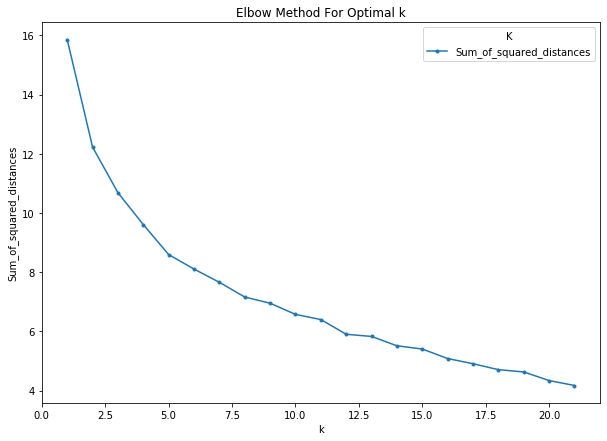

In [87]:
# Here we find the best K with the elbow method (change of slope)
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(1, 22)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(barrios_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k
optimal_k.plot(kind = 'line', figsize = (10, 7), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Based on the above graph 8 to 12 seems to be the best values for k
I personally checked Barcelona with k=12 and it's not very significant, I'd keep K under 10

In [88]:
######################################################################
#             Actual clustering algorithm is launched here           #
######################################################################

kclusters = 10
barrios_grouped_clustering = barrios_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barrios_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 2, 3, 3, 1, 5, 9, 4, 3], dtype=int32)

In [89]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
barrios_merged = barrios_of_interest_merged
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
barrios_merged = barrios_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
barrios_merged.head() # check the last columns!
#downtown_toronto_merged.shape

#Some neighborhood fall into NaN category, we eliminate them.
barrios_merged.dropna(inplace=True)
barrios_merged['Cluster Labels']
barrios_of_interest_merged.head()

,Neighborhood,Latitude,Longitude
0,BARCELONA | Baró de Viver,41.445934,2.198788
1,BARCELONA | Bon Pastor,41.436110,2.204807
2,BARCELONA | Can Baró,41.416966,2.162693
3,BARCELONA | Can Peguera,41.434928,2.166548
4,BARCELONA | Canyelles,41.285827,1.722274


In [90]:
# We find the point in the middle between the two cities to center the map
p1_x=barrios_of_interest.loc[0, 'Latitude']
p1_y= barrios_of_interest.loc[0, 'Longitude']

p2_x=barrios_of_interest_2.loc[0, 'Latitude']
p2_y= barrios_of_interest_2.loc[0, 'Longitude']

pCenter_lat=(p1_x+p2_x)/2
pCenter_lng=(p1_y+p2_y)/2

In [95]:
###########################################################################
#      Map the City with the neighborhoods colored by cluster label       #
###########################################################################

# Not sure why it complains of floats depending on the Borough!
barrios_merged['Cluster Labels']=barrios_merged['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[pCenter_lat, pCenter_lng], zoom_start=7, tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Paired(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barrios_merged['Latitude'], barrios_merged['Longitude'], barrios_merged['Neighborhood'], barrios_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [92]:
from IPython.display import display, HTML

for i in range(kclusters):
    print("CLUSTER LABEL: {}".format(i))
    #tx=barrios_merged.loc[barrios_merged['Cluster Labels'] == i, barrios_merged.columns[[0] + list(range(4, barrios_merged.shape[1]))]]
    tx=barrios_merged.loc[barrios_merged['Cluster Labels'] == i, barrios_merged.columns[[0] + list(range(4, 5))]]
    display(tx)

CLUSTER LABEL: 0


,Neighborhood,1st Most Common Venue
137,MADRID | Aluche,Beer
153,MADRID | Zofio,Sport
154,MADRID | Pradolongo,Park
160,MADRID | Numancia,Beer


CLUSTER LABEL: 1


,Neighborhood,1st Most Common Venue
0,BARCELONA | Baró de Viver,Furniture / Home Store
2,BARCELONA | Can Baró,Scenic Lookout
8,BARCELONA | Horta,Park
13,BARCELONA | Pedralbes,Garden
16,BARCELONA | Porta,Plaza
18,BARCELONA | Sant Andreu,Clothing Store
25,BARCELONA | Santa Caterina i la Ribera,Beauty Salon
33,BARCELONA | Vallvidrera,Plaza
34,BARCELONA | Verdun,Park
35,BARCELONA | Vilapicina i la Torre Llobeta,Bookstore


CLUSTER LABEL: 2


,Neighborhood,1st Most Common Venue
1,BARCELONA | Bon Pastor,Sport
7,BARCELONA | Fort Pienc,Sport
10,BARCELONA | Les Roquetes,Sport
11,BARCELONA | Montbau,Sport
12,BARCELONA | Navas,Sport
17,BARCELONA | Provençals del Poblenou,Sport
22,BARCELONA | Sant Gervasi-la Bonanova,Sport
44,BARCELONA | el Guinardó,Sport
49,BARCELONA | el Tibidabo i les Planes,Sport
69,BARCELONA | la Trinitat Vella,Sport


CLUSTER LABEL: 3


,Neighborhood,1st Most Common Venue
6,BARCELONA | Diagonal Mar i el Front Marítim de...,Sport
9,BARCELONA | Hostafrancs,Hotel
14,BARCELONA | Poble-sec,Hotel
15,BARCELONA | Poblenou,Bakery
19,BARCELONA | Sant Antoni,Bookstore
21,BARCELONA | Sant Gervasi-Galvany,Hotel
26,BARCELONA | Sants,Hotel
27,BARCELONA | Sants - Badal,Bakery
28,BARCELONA | Sarrià,Bakery
29,BARCELONA | Superficie,Hotel


CLUSTER LABEL: 4


,Neighborhood,1st Most Common Venue
5,BARCELONA | Ciutat Meridiana,Transport
31,BARCELONA | Vallbona,Transport
67,BARCELONA | la Teixonera,Transport
124,MADRID | Valverde,Bakery
126,MADRID | El Goloso,Transport
139,MADRID | Cuatro Vientos,Transport
155,MADRID | Entrevías,Sport
158,MADRID | Palomeras Sureste,Transport
174,MADRID | Atalaya,Sport
182,MADRID | Villaverde,Sport


CLUSTER LABEL: 5


,Neighborhood,1st Most Common Venue
3,BARCELONA | Can Peguera,Park
54,BARCELONA | la Clota,Park
120,MADRID | Fuentelarreina,Park
123,MADRID | La Paz,Sport
136,MADRID | Lucero,Park
157,MADRID | Palomeras Bajas,Toy / Game Store
163,MADRID | Marroquina,Park
181,MADRID | Valdefuentes,Park
184,MADRID | Butarque,Plaza
194,MADRID | Simancas,Park


CLUSTER LABEL: 6


,Neighborhood,1st Most Common Venue
127,MADRID | Casa de Campo,Trail


CLUSTER LABEL: 7


,Neighborhood,1st Most Common Venue
30,BARCELONA | Torre Baró,Scenic Lookout


CLUSTER LABEL: 8


,Neighborhood,1st Most Common Venue
198,MADRID | Rosas,Electronics Store


CLUSTER LABEL: 9


,Neighborhood,1st Most Common Venue
4,BARCELONA | Canyelles,Sport
20,BARCELONA | Sant Genís dels Agudells,Sport
23,BARCELONA | Sant Martí de Provençals,Sport
56,BARCELONA | la Font d en Fargues,Sport
61,BARCELONA | la Maternitat i Sant Ramon,Sport
70,BARCELONA | Vall d'Hebron,Sport
130,MADRID | Valdezarza,Sport
159,MADRID | Portazgo,Sport
162,MADRID | Horcajo,Sport
177,MADRID | Piovera,Sport
